VAE mnist

In [0]:
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf

import keras
from keras.utils import np_utils
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

VLB

In [0]:
def vlb_bernoulli(x, x_decoded_mean, t_mean, t_log_var):
    '''    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) 
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of normal distribution q(t | x)
        t_log_var: (batch_size x latent_dim) log variance vector of normal distribution q(t | x)    
    '''
    # reconstruction loss
    # Binary cross-entropy which is commonly used for data like MNIST that can be modeled as Bernoulli trials.
    # https://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html
    # x is originally 0 to 255, after dividing by 255 we get float numbers ranging from 0 to 1
    loss = tf.reduce_sum(x * K.log(x_decoded_mean + 1e-10) + (1 - x) * K.log(1 - x_decoded_mean + 1e-10), axis=1)

    # KL divergence
    regularisation = 0.5 * tf.reduce_sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=1)

    vlb = tf.reduce_mean(loss + regularisation)

    return -vlb # return negative scalar value (tf.Tensor) of variational Lower Bound for minimization

Setup tf interactive session & connect it with keras.

In [0]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [4]:
batch_size = 1000
original_dim = 784 # Number of pixels
latent_dim = 64 # d, dimensionality of the latent code t.
hidden = 32 # Size of the hidden layer.
epochs = 30

x = Input(batch_shape=(batch_size, original_dim))

Encoder

In [5]:
def create_encoder(input_dim):
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(hidden, activation='relu'))
    encoder.add(Dense(hidden, activation='relu'))
    encoder.add(Dense(hidden, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder


encoder = create_encoder(original_dim)
h = encoder(x)

Output mean & log variance.

In [0]:
get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])

t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

Sampling from the distribution q(t | x) = N(t_mean, exp(t_log_var)) with reparametrization trick.

In [7]:
def sampling(args):
    '''       
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the distribution
        args[1]: (batch_size x latent_dim) vector of log variance, diag of conv matrix of distribution
    '''
    t_mean, t_log_var = args

    e = K.random_normal(shape=(batch_size, latent_dim))
    samples = t_mean + K.exp(0.5 * t_log_var) * e # use t_log_sigma instead of t_log_var

    return samples # tf.Tensor of size (batch_size x latent_dim) from Gaussian distribution N(args[0], diag(args[1]))


t = Lambda(sampling)([t_mean, t_log_var])

Decoder

In [0]:
def create_decoder(input_dim):
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(hidden, activation='relu'))
    decoder.add(Dense(hidden, activation='relu'))
    decoder.add(Dense(hidden, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
    

decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

Setup the model.

In [9]:
loss = vlb_bernoulli(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)

# In the loss argument, x is input (x), y is output(x_decoded_mean)
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: loss)

Load & process data.

In [10]:
# https://corochann.com/mnist-dataset-introduction-1138.html

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(y_train.shape)
print(y_train[301])

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print(y_train.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_train.shape[1:])
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train[100][300:350])

(60000,)
7
(60000, 10)
(60000, 28, 28)
(28, 28)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.6156863  0.99215686 0.99215686 0.49019608 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.34901962 0.99215686
 0.98039216 0.22352941]


Train the model.

In [11]:
hist = vae.fit(x=x_train, 
               y=x_train, # note that y is not y_train
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, x_test), # note x_test is used in the 2nd input, not y_test
               verbose=2)




Train on 60000 samples, validate on 10000 samples
Epoch 1/30




 - 1s - loss: 284.4286 - val_loss: 212.1735
Epoch 2/30
 - 0s - loss: 206.1978 - val_loss: 200.3780
Epoch 3/30
 - 0s - loss: 198.1321 - val_loss: 195.9004
Epoch 4/30
 - 0s - loss: 195.6656 - val_loss: 193.7336
Epoch 5/30
 - 0s - loss: 192.4686 - val_loss: 189.3810
Epoch 6/30
 - 0s - loss: 188.2176 - val_loss: 185.8131
Epoch 7/30
 - 0s - loss: 185.2489 - val_loss: 183.7366
Epoch 8/30
 - 0s - loss: 183.7172 - val_loss: 182.8851
Epoch 9/30
 - 0s - loss: 182.4924 - val_loss: 180.6528
Epoch 10/30
 - 0s - loss: 181.0188 - val_loss: 179.5549
Epoch 11/30
 - 0s - loss: 179.1626 - val_loss: 177.2230
Epoch 12/30
 - 1s - loss: 177.2191 - val_loss: 175.2295
Epoch 13/30
 - 0s - loss: 175.3769 - val_loss: 174.3589
Epoch 14/30
 - 0s - loss: 173.5284 - val_loss: 172.1894
Epoch 15/30
 - 0s - loss: 171.7121 - val_loss: 170.2674
Epoch 16/30
 - 0s - loss: 169.7374 - val_loss: 167.7636
Epoch 17/30
 - 0s - loss: 167.5861 - val_loss: 165.9840


Plot mnist & generated output. 

mnist(left col) vs generated(right col) for both training(left image) & validation data(right image).

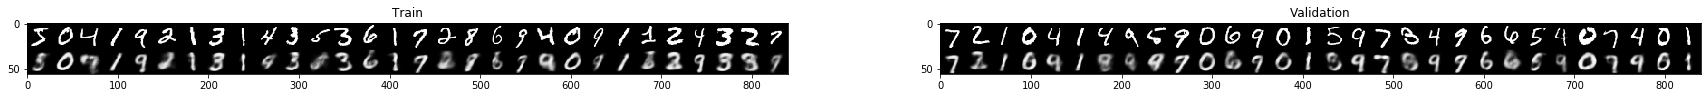

In [21]:
fig = plt.figure(figsize=(30, 30))

for fid_idx, (data, title) in enumerate(zip([x_train, x_test], ['Train', 'Validation'])):

    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * 2, digit_size * n)) # 2 rows, n cols

    # Generate new data
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})

    for i in range(n):
        row_start = i * digit_size
        row_end = (i + 1) * digit_size
        col_end = digit_size
        # data
        figure[:digit_size, row_start:row_end] = data[i, :].reshape(digit_size, digit_size)

        # decoded
        figure[digit_size:, row_start:row_end] = decoded[i, :].reshape(digit_size, digit_size)

        #print('data', data[i, :][300:305])
        #print('decoded', decoded[i, :][300:305])

    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)

plt.show()

Sample from the prior distribution $p(t)$ (Gaussian) and then from the likelihood $p(x \mid t)$.

In [13]:
t_mean_norm = K.random_normal(shape=(batch_size, latent_dim))
t_log_var_norm = K.random_normal(shape=(batch_size, latent_dim))
#p_t = Lambda(sampling)([t_mean_norm, t_log_var_norm])

def p_t_sampling(args):
  return K.random_normal(shape=(batch_size, latent_dim))
p_t = Lambda(p_t_sampling)([])

# images sampled from the vae model.
sampled_im_mean = decoder(p_t)
print(sampled_im_mean.shape)

(1000, 784)


Generate & plot new data.


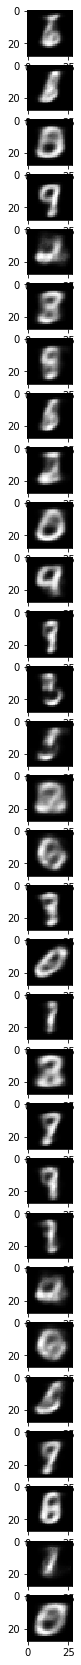

In [18]:
# Generate data
sampled_im_mean_np = sess.run(sampled_im_mean)


# Plot images
n_samples = 30 # sample size

plt.figure(figsize=(30, 30))

for i in range(n_samples):
    ax = plt.subplot(n_samples, 1, i + 1) # row, col, index
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')

plt.show()

References:

VAE paper:
https://arxiv.org/pdf/1312.6114.pdfhttps://arxiv.org/pdf/1312.6114.pdf